# 최근접 이웃(K-Nearest Neighbor)

* 특별한 예측 모델 없이 가장 가까운 데이터 포인트를 기반으로 예측을 수행하는 방법
* 분류와 회귀 모두 지원

![k nearest neighbor](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)

In [30]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import warnings
plt.style.use(['seaborn-whitegrid'])

warnings.filterwarnings(action='ignore')

In [62]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris, load_breast_cancer, load_boston, fetch_california_housing, load_wine
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score

## K 최근접 이웃 분류

* 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
* k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과

### 붓꽃 데이터

In [4]:
iris = load_iris()
iris_df = pd.DataFrame(data = iris.data, columns = iris.feature_names)
iris_df['Target'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [7]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   Target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [8]:
X, y = load_iris(return_X_y=True)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [9]:
scaler = StandardScaler()
scale_train_X = scaler.fit_transform(train_X)
scale_test_X = scaler.transform(test_X)

In [10]:
model = KNeighborsClassifier()
model.fit(train_X, train_y)

KNeighborsClassifier()

In [14]:
print("train data score : {}".format(model.score(train_X, train_y)))
print("test data score : {}".format(model.score(test_X, test_y)))

train data score : 0.9809523809523809
test data score : 0.9555555555555556


In [11]:
preds = model.predict(test_X)

In [15]:
scale_model = KNeighborsClassifier()
scale_model.fit(scale_train_X, train_y)
print("train data score : {}".format(scale_model.score(scale_train_X, train_y)))
print("test data score : {}".format(scale_model.score(scale_test_X, test_y)))

train data score : 0.9809523809523809
test data score : 0.9111111111111111


In [17]:
cross_validate(
    estimator=KNeighborsClassifier(),
    X=X, y=y,
    cv = 5,
    n_jobs=-1,
    verbose=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


{'fit_time': array([0.        , 0.00100398, 0.00100279, 0.00100398, 0.        ]),
 'score_time': array([0.00100398, 0.        , 0.        , 0.00100279, 0.00100374]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])}

In [18]:
param_grid = [{'n_neighbors' : [3, 5, 7],
               'weights' : ['uniform', 'distance'],
               'algorithm' : ['ball_tree', 'kd_tree', 'brute']}]

In [19]:
gs = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    n_jobs=-1,
    verbose=True
)

In [24]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=True)

In [25]:
gs.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7)

In [26]:
gs.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'uniform'}

In [27]:
gs.best_score_

0.9800000000000001

In [36]:
def make_meshgrid(x, y, h=.02):
    min_x, max_x = x.min()-1, x.max()+1
    min_y, max_y = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(min_x, max_x, h),
                         np.arange(min_y, max_y, h))
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    
    return out

In [31]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [32]:
iris_comp_df = pd.DataFrame(data = X_comp)
iris_comp_df['Target'] = y
iris_comp_df.head()

,0,1,Target
0,-27.064329,-0.638706,0
1,-29.635300,0.485486,0
2,-29.767790,-0.746114,0
3,-30.118536,-0.440579,0
4,-27.057741,-1.124737,0


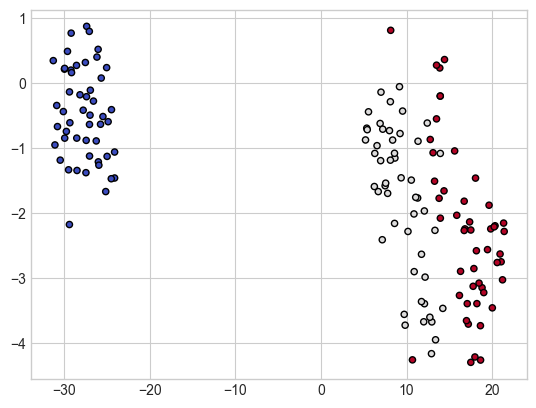

In [33]:
plt.scatter(X_comp[:,0], X_comp[:,1],
            c = y, cmap = plt.cm.coolwarm, s = 20, edgecolors='k');

In [34]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
preds = model.predict(X_comp)

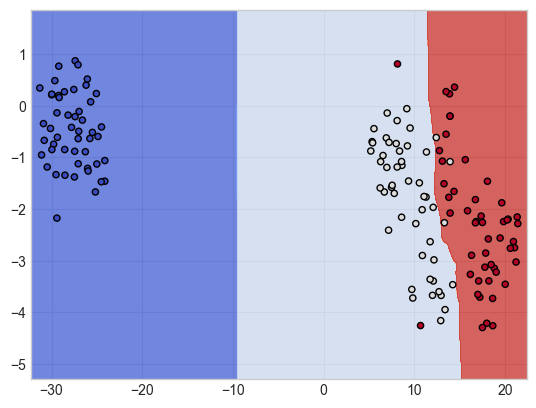

In [37]:
xx, yy = make_meshgrid(X_comp[:,0],X_comp[:,1])
plot_contours(model, xx, yy, cmap = plt.cm.coolwarm, alpha = 0.8)
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

### 유방암 데이터

In [38]:
cancer = load_breast_cancer()

In [39]:
cancer_df = pd.DataFrame(data = cancer.data, columns=cancer.feature_names)
cancer_df['Target'] = cancer.target
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [40]:
X, y= cancer.data, cancer.target
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [41]:
cancer_train_df = pd.DataFrame(data=train_X, columns=cancer.feature_names)
cancer_train_df['target'] = train_y
cancer_train_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,15.37,22.76,100.20,728.2,0.09200,0.10360,0.11220,0.07483,0.1717,0.06097,...,25.84,107.50,830.9,0.1257,0.1997,0.2846,0.14760,0.2556,0.06828,0
1,16.13,17.88,107.00,807.2,0.10400,0.15590,0.13540,0.07752,0.1998,0.06515,...,27.26,132.70,1261.0,0.1446,0.5804,0.5274,0.18640,0.4270,0.12330,0
2,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,...,23.02,89.69,580.9,0.1172,0.1958,0.1810,0.08388,0.3297,0.07834,1
3,10.29,27.61,65.67,321.4,0.09030,0.07658,0.05999,0.02738,0.1593,0.06127,...,34.91,69.57,357.6,0.1384,0.1710,0.2000,0.09127,0.2226,0.08283,1
4,20.94,23.56,138.90,1364.0,0.10070,0.16060,0.27120,0.13100,0.2205,0.05898,...,27.00,165.30,2010.0,0.1211,0.3172,0.6991,0.21050,0.3126,0.07849,0


In [42]:
cancer_test_df = pd.DataFrame(data=test_X, columns=cancer.feature_names)
cancer_test_df['target'] = test_y
cancer_test_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,10.88,15.62,70.41,358.9,0.10070,0.10690,0.05115,0.01571,0.1861,0.06837,...,19.35,80.78,433.1,0.1332,0.3898,0.33650,0.07966,0.2581,0.10800,1
1,16.65,21.38,110.00,904.6,0.11210,0.14570,0.15250,0.09170,0.1995,0.06330,...,31.56,177.00,2215.0,0.1805,0.3578,0.46950,0.20950,0.3613,0.09564,0
2,15.27,12.91,98.17,725.5,0.08182,0.06230,0.05892,0.03157,0.1359,0.05526,...,15.92,113.70,932.7,0.1222,0.2186,0.29620,0.10350,0.2320,0.07474,1
3,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,0.1771,0.06072,...,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784,1
4,12.27,17.92,78.41,466.1,0.08685,0.06526,0.03211,0.02653,0.1966,0.05597,...,28.88,89.00,610.2,0.1240,0.1795,0.13770,0.09532,0.3455,0.06896,1


In [43]:
scaler = StandardScaler()
scale_train_X = scaler.fit_transform(train_X)
scale_test_X = scaler.transform(test_X)

In [44]:
model = KNeighborsClassifier()
model.fit(train_X, train_y)

KNeighborsClassifier()

In [45]:
print("train data score : {}".format(model.score(train_X, train_y)))
print("test data score : {}".format(model.score(test_X, test_y)))

train data score : 0.9522613065326633
test data score : 0.9298245614035088


In [46]:
preds = model.predict(test_X)

In [47]:
scale_model = KNeighborsClassifier()
scale_model.fit(scale_train_X, train_y)
print("train data score : {}".format(scale_model.score(scale_train_X, train_y)))
print("test data score : {}".format(scale_model.score(scale_test_X, test_y)))

train data score : 0.9698492462311558
test data score : 0.9883040935672515


In [48]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [49]:
cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=-1,
    verbose=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


{'fit_time': array([0.00100279, 0.        , 0.        , 0.00100279, 0.00100279]),
 'score_time': array([0.00401449, 0.00501728, 0.00501728, 0.00401449, 0.00401449]),
 'test_score': array([0.96491228, 0.95614035, 0.98245614, 0.95614035, 0.96460177])}

In [50]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsClassifier())]
)

In [51]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights' : ['uniform', 'distance'],
               'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']}]

In [52]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv = 5,
    n_jobs=-1,
    verbose=True
)

In [53]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [54]:
gs.best_params_

{'model__algorithm': 'ball_tree',
 'model__n_neighbors': 7,
 'model__weights': 'uniform'}

In [55]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7))])

In [56]:
gs.best_score_

0.9701288619779538

In [57]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [58]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['Target'] = y
cancer_comp_df.head()

,0,1,Target
0,-10.028691,30.181250,0
1,-8.717471,32.628613,0
2,-4.811297,29.989658,0
3,-4.524974,-23.897837,0
4,-2.590505,30.967762,0


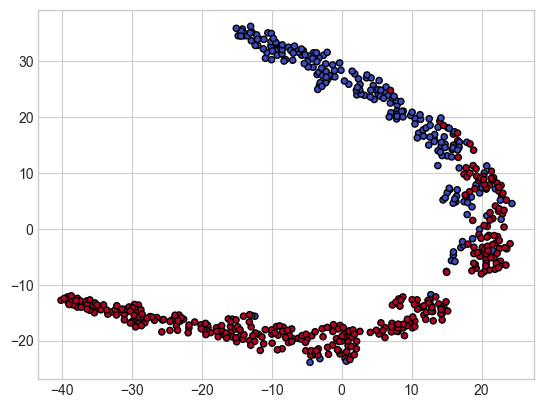

In [59]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s = 20, edgecolors='k');

In [60]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

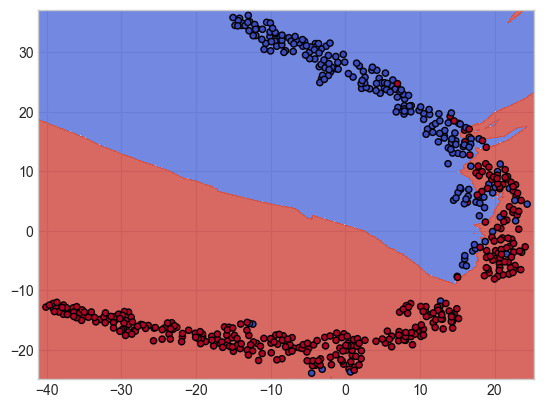

In [61]:
xx, yy = make_meshgrid(X_comp[:,0],X_comp[:,1])
plot_contours(model, xx, yy, cmap = plt.cm.coolwarm, alpha = 0.8)
plt.scatter(X_comp[:,0],X_comp[:,1], c = y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

### 와인 데이터

In [64]:
wine = load_wine()

In [65]:
wine_df = pd.DataFrame(data = wine.data, columns=wine.feature_names)
wine_df['Target'] = wine.target
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [66]:
X, y= wine.data, wine.target
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [67]:
wine_train_df = pd.DataFrame(data=train_X, columns=wine.feature_names)
wine_train_df['target'] = train_y
wine_train_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.51,1.80,2.65,19.0,110.0,2.35,2.53,0.29,1.54,4.20,1.100,2.87,1095.0,0
1,11.65,1.67,2.62,26.0,88.0,1.92,1.61,0.40,1.34,2.60,1.360,3.21,562.0,1
2,12.29,1.61,2.21,20.4,103.0,1.10,1.02,0.37,1.46,3.05,0.906,1.82,870.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.180,2.69,1020.0,0
4,11.79,2.13,2.78,28.5,92.0,2.13,2.24,0.58,1.76,3.00,0.970,2.44,466.0,1


In [68]:
wine_test_df = pd.DataFrame(data=test_X, columns=wine.feature_names)
wine_test_df['target'] = test_y
wine_test_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.05,2.05,3.22,25.0,124.0,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830.0,0
1,14.06,1.63,2.28,16.0,126.0,3.00,3.17,0.24,2.10,5.65,1.09,3.71,780.0,0
2,14.38,3.59,2.28,16.0,102.0,3.25,3.17,0.27,2.19,4.90,1.04,3.44,1065.0,0
3,12.70,3.55,2.36,21.5,106.0,1.70,1.20,0.17,0.84,5.00,0.78,1.29,600.0,2
4,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0


In [69]:
scaler = StandardScaler()
scale_train_X = scaler.fit_transform(train_X)
scale_test_X = scaler.transform(test_X)

In [70]:
model = KNeighborsClassifier()
model.fit(train_X, train_y)

KNeighborsClassifier()

In [71]:
print("train data score : {}".format(model.score(train_X, train_y)))
print("test data score : {}".format(model.score(test_X, test_y)))

train data score : 0.8145161290322581
test data score : 0.7222222222222222


In [72]:
preds = model.predict(test_X)

In [73]:
scale_model = KNeighborsClassifier()
scale_model.fit(scale_train_X, train_y)
print("train data score : {}".format(scale_model.score(scale_train_X, train_y)))
print("test data score : {}".format(scale_model.score(scale_test_X, test_y)))

train data score : 0.967741935483871
test data score : 0.9444444444444444


In [74]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [75]:
cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=-1,
    verbose=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.        , 0.00200677, 0.00100374, 0.00100327, 0.        ]),
 'score_time': array([0.0010035 , 0.0010035 , 0.00200677, 0.00200748, 0.00200605]),
 'test_score': array([0.94444444, 0.94444444, 0.97222222, 1.        , 0.88571429])}

In [76]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsClassifier())]
)

In [77]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights' : ['uniform', 'distance'],
               'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']}]

In [78]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv = 5,
    n_jobs=-1,
    verbose=True
)

In [79]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [80]:
gs.best_params_

{'model__algorithm': 'ball_tree',
 'model__n_neighbors': 7,
 'model__weights': 'uniform'}

In [81]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7))])

In [82]:
gs.best_score_

0.9665079365079364

In [83]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [84]:
wine_comp_df = pd.DataFrame(data=X_comp)
wine_comp_df['Target'] = y
wine_comp_df.head()

,0,1,Target
0,-6.848834,9.897004,0
1,-7.180067,9.191945,0
2,-8.442442,11.440044,0
3,-10.170460,13.680157,0
4,-1.631364,2.828111,0


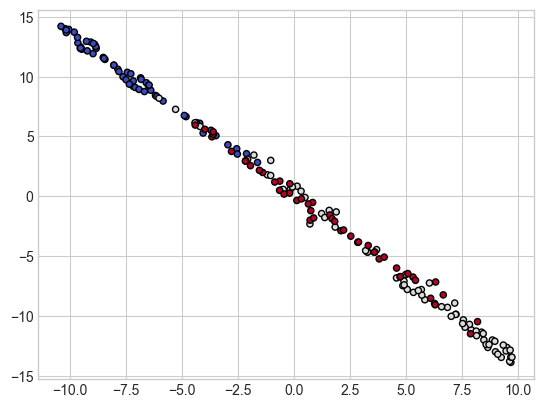

In [85]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s = 20, edgecolors='k');

In [86]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

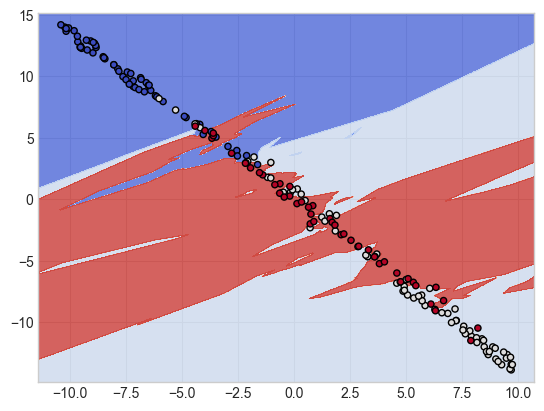

In [87]:
xx, yy = make_meshgrid(X_comp[:,0],X_comp[:,1])
plot_contours(model, xx, yy, cmap = plt.cm.coolwarm, alpha = 0.8)
plt.scatter(X_comp[:,0],X_comp[:,1], c = y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

## k 최근접 이웃 회귀

* k 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
* 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격 데이터

In [88]:
boston = load_boston()

In [89]:
boston_df = pd.DataFrame(data = boston.data, columns=boston.feature_names)
boston_df['Target'] = boston.target
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [90]:
X, y= boston.data, boston.target
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [91]:
boston_train_df = pd.DataFrame(data=train_X, columns=boston.feature_names)
boston_train_df['target'] = train_y
boston_train_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,1.25179,0.0,8.14,0.0,0.538,5.570,98.1,3.7979,4.0,307.0,21.0,376.57,21.02,13.6
1,0.09512,0.0,12.83,0.0,0.437,6.286,45.0,4.5026,5.0,398.0,18.7,383.23,8.94,21.4
2,0.13058,0.0,10.01,0.0,0.547,5.872,73.1,2.4775,6.0,432.0,17.8,338.63,15.37,20.4
3,4.75237,0.0,18.10,0.0,0.713,6.525,86.5,2.4358,24.0,666.0,20.2,50.92,18.13,14.1
4,1.05393,0.0,8.14,0.0,0.538,5.935,29.3,4.4986,4.0,307.0,21.0,386.85,6.58,23.1


In [92]:
boston_test_df = pd.DataFrame(data=test_X, columns=boston.feature_names)
boston_test_df['target'] = test_y
boston_test_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.02763,75.0,2.95,0.0,0.428,6.595,21.8,5.4011,3.0,252.0,18.3,395.63,4.32,30.8
1,0.09068,45.0,3.44,0.0,0.437,6.951,21.5,6.4798,5.0,398.0,15.2,377.68,5.10,37.0
2,18.81100,0.0,18.10,0.0,0.597,4.628,100.0,1.5539,24.0,666.0,20.2,28.79,34.37,17.9
3,0.07886,80.0,4.95,0.0,0.411,7.148,27.7,5.1167,4.0,245.0,19.2,396.90,3.56,37.3
4,0.44178,0.0,6.20,0.0,0.504,6.552,21.4,3.3751,8.0,307.0,17.4,380.34,3.76,31.5


In [93]:
scaler = StandardScaler()
scale_train_X = scaler.fit_transform(train_X)
scale_test_X = scaler.transform(test_X)

In [94]:
model = KNeighborsRegressor()
model.fit(train_X, train_y)

KNeighborsRegressor()

In [95]:
print("train data score : {}".format(model.score(train_X, train_y)))
print("test data score : {}".format(model.score(test_X, test_y)))

train data score : 0.6830088864382646
test data score : 0.558458189238069


In [96]:
scale_model = KNeighborsRegressor()
scale_model.fit(scale_train_X, train_y)
print("train data score : {}".format(scale_model.score(scale_train_X, train_y)))
print("test data score : {}".format(scale_model.score(scale_test_X, test_y)))

train data score : 0.8282493885472638
test data score : 0.7536322941824347


In [97]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [98]:
cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=-1,
    verbose=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00058651, 0.00200868, 0.00200701, 0.00200701, 0.0010035 ]),
 'score_time': array([0.00099468, 0.00100183, 0.00100374, 0.00200725, 0.00100303]),
 'test_score': array([0.56089547, 0.61917359, 0.48661916, 0.46986886, 0.23133037])}

In [99]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsRegressor())]
)

In [100]:
param_grid = [{'model__n_neighbors': [3, 5, 7],
               'model__weights' : ['uniform', 'distance'],
               'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']}]

In [101]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv = 5,
    n_jobs=-1,
    verbose=True
)

In [102]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [103]:
gs.best_params_

{'model__algorithm': 'ball_tree',
 'model__n_neighbors': 7,
 'model__weights': 'distance'}

In [104]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7,
                                     weights='distance'))])

In [105]:
gs.best_score_

0.4973060611762845

In [110]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

In [111]:
boston_comp_df = pd.DataFrame(data=X_comp)
boston_comp_df['Target'] = y
boston_comp_df.head()

,0,Target
0,25.662245,24.0
1,46.975327,21.6
2,43.194717,34.7
3,44.152550,33.4
4,44.415928,36.2


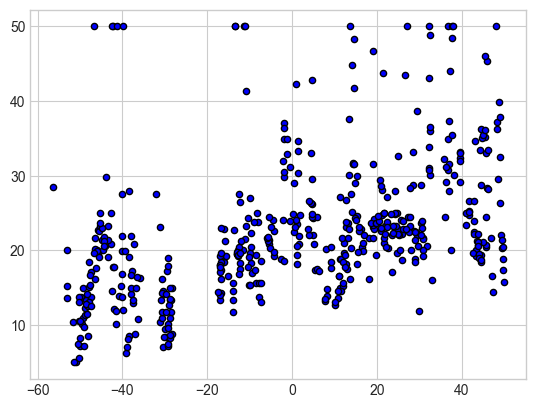

In [113]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s = 20, edgecolors='k');

In [115]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

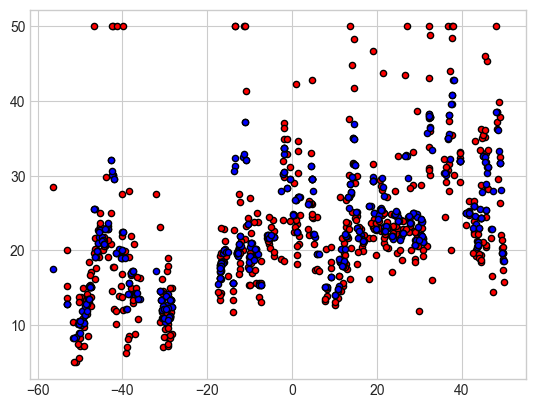

In [119]:
plt.scatter(X_comp, y, c = 'r', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
plt.scatter(X_comp, predict, c = 'b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');